In [ ]:
#This notebook runs the full ingestion→cleaning→storage pipeline via the `ingest.py` script, then reads the merged data and produces key exploratory charts:

#1. Price history  
#2. Returns distributions  
#3. Returns correlation heatmap  
#4. Drawdown curve  

In [2]:
import data_utils
print(data_utils.__file__)


c:\Users\yusef\Desktop\Market-Data-Pipeline-Descriptive-Analytics\data_utils.py


In [3]:
from data_utils import cache
cache.clear(warn=False)
print("Cache cleared")


Cache cleared


In [4]:
from data_utils import load_tickers, get_ticker_data

symbols = load_tickers("symbols.txt")
for sym in symbols:
    df = get_ticker_data(sym, start="2015-01-01", end=None)
    print(f"{sym:6} → rows: {len(df):4}, index: {type(df.index).__name__}")

________________________________________________________________________________
[Memory] Calling data_utils.get_ticker_data...
get_ticker_data('AAPL', start='2015-01-01', end=None)
__________________________________________________get_ticker_data - 1.0s, 0.0min
AAPL   → rows: 2644, index: DatetimeIndex
________________________________________________________________________________
[Memory] Calling data_utils.get_ticker_data...
get_ticker_data('MSFT', start='2015-01-01', end=None)
__________________________________________________get_ticker_data - 0.5s, 0.0min
MSFT   → rows: 2644, index: DatetimeIndex
________________________________________________________________________________
[Memory] Calling data_utils.get_ticker_data...
get_ticker_data('AMZN', start='2015-01-01', end=None)
__________________________________________________get_ticker_data - 0.4s, 0.0min
AMZN   → rows: 2644, index: DatetimeIndex
________________________________________________________________________________
[Mem

In [5]:
from data_utils import clean_data

cleaned = clean_data(get_ticker_data(symbols[0], start="2015-01-01"), max_gap=2)
print("Cleaned rows:", len(cleaned), "Index dtype:", cleaned.index.dtype)
cleaned.head()

Cleaned rows: 2744 Index dtype: datetime64[ns]


Price,close,high,low,open,volume
Date,,,,,
2015-01-02,24.288580,24.757334,23.848706,24.746226,212818400.0
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000.0
2015-01-06,23.606556,23.866481,23.244437,23.668760,263188400.0
2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600.0
2015-01-08,24.857306,24.915067,24.148620,24.266365,237458000.0


In [6]:
from ingest import main

main(
    symbols_path="symbols.txt",
    out_clean="data/clean",
    out_merged="data/prices.parquet",
    start="2015-01-01",
    end=None
)
print("Pipeline complete")

Pipeline complete


In [7]:
import pandas as pd

prices = pd.read_parquet("data/prices.parquet")
print("Merged table:", prices.shape)
prices.head()

Merged table: (2744, 7)


,AAPL,MSFT,AMZN,GOOGL,JNJ,KO,SPY
Date,,,,,,,
2015-01-02,24.288580,39.998707,15.4260,26.319654,78.012619,30.222614,171.568039
2015-01-05,23.604332,39.630898,15.1095,25.818157,77.467758,30.222614,168.469528
2015-01-06,23.606556,39.049206,14.7645,25.180983,77.087090,30.452110,166.882782
2015-01-07,23.937574,39.545349,14.9210,25.106926,78.788857,30.832235,168.962326
2015-01-08,24.857306,40.708683,15.0230,25.194403,79.408363,31.205179,171.960587


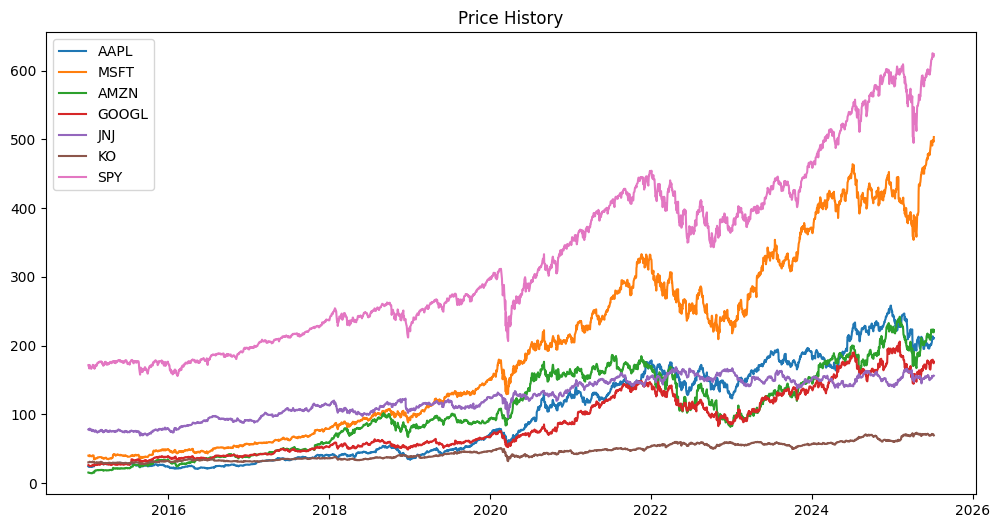

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for sym in prices.columns:
    plt.plot(prices.index, prices[sym], label=sym)
plt.title("Price History")
plt.legend(loc="upper left")
plt.show()


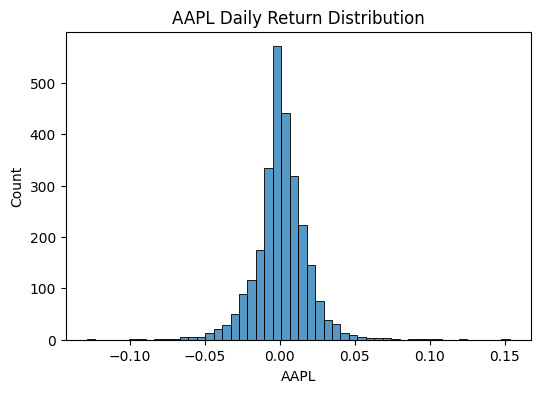

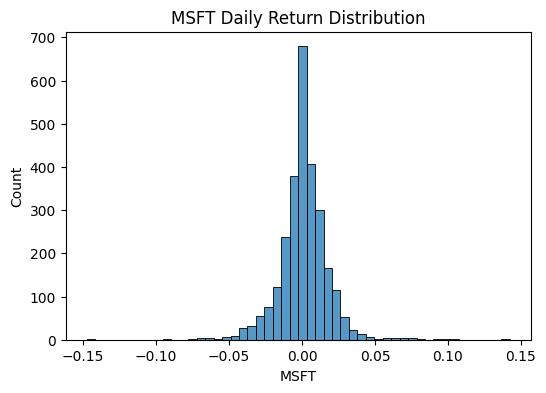

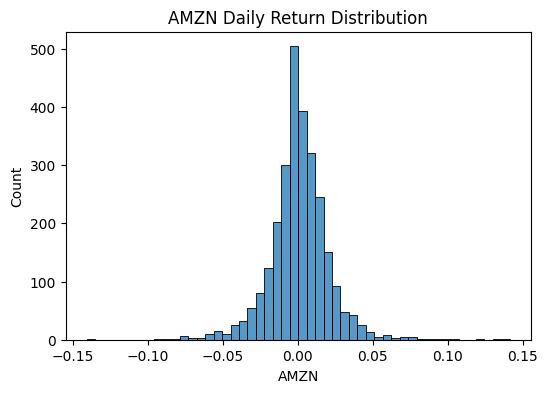

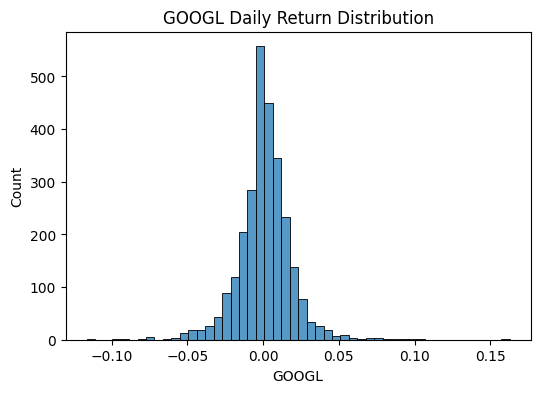

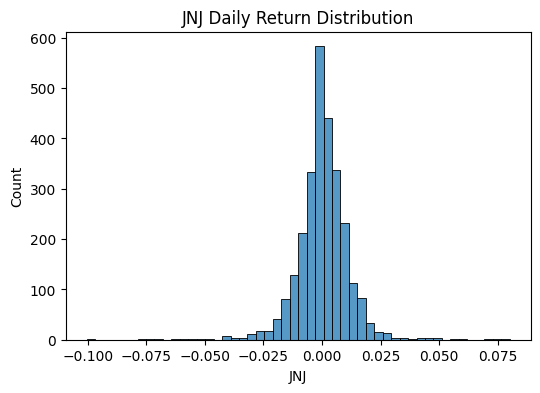

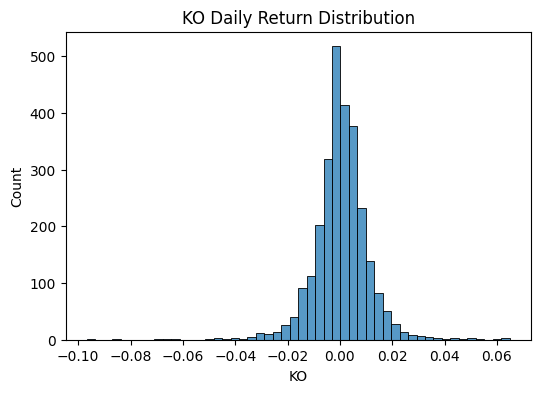

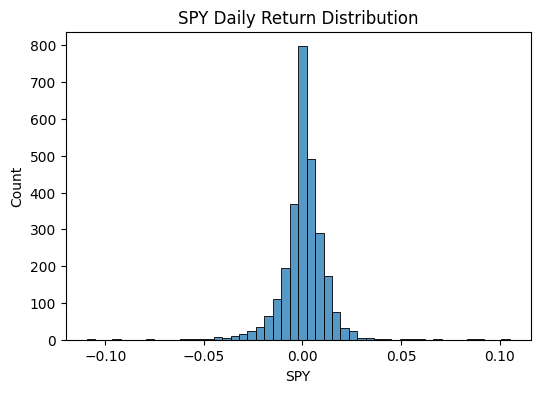

In [9]:
import seaborn as sns

returns = prices.pct_change().dropna()
for sym in prices.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(returns[sym], bins=50, kde=False)
    plt.title(f"{sym} Daily Return Distribution")
    plt.show()

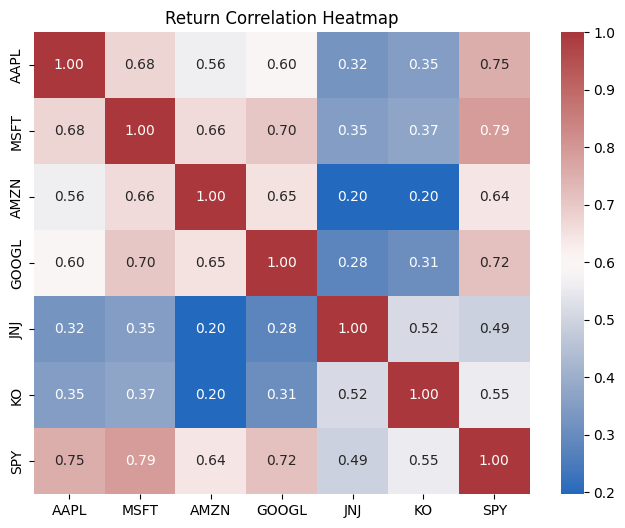

In [10]:
corr = returns.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Return Correlation Heatmap")
plt.show()

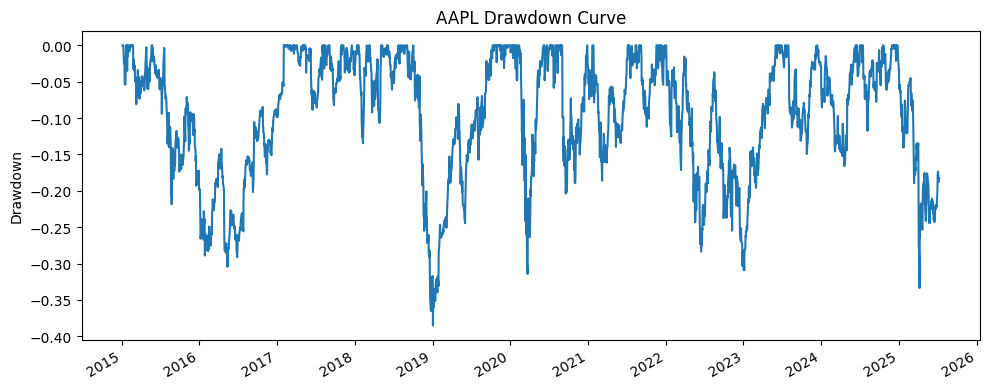

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sym0 = prices.columns[0]
cum   = (1 + returns[sym0]).cumprod()
drawd = cum / cum.cummax() - 1

#  Create fig & axis
fig, ax = plt.subplots(figsize=(10,4))

#  Plot drawdown
ax.plot(drawd.index, drawd, label=sym0)

# Titles & labels
ax.set_title(f"{sym0} Drawdown Curve")
ax.set_ylabel("Drawdown")

# Format the x-axis to one tick per year and rotate labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Tighten margins so nothing is cut off
fig.tight_layout()

plt.show()
